In [1]:
from IPython.display import Image, display

from langchain_mcp_adapters.client import MultiServerMCPClient

from react_agent.src.agents.react_agent import ReActAgent
from react_agent.src.agents.triage import Triage

from react_agent.src.config.system_parameters import TriageSettings

from react_agent.src.util.tools_fabric import ToolsFabric

In [2]:
USE_MCP = False
DEBUG_MODE = True
USE_TRIAGE = False

In [3]:
mapping_question = "Explain how 'Payment Terms' is mapped. Start with 'map_invoice1'."
extensibility_question = "As a Public Cloud customer in Spain, can I extend an existing eDocument customer invoice Process?"
peppol_support = "We as Syntax are currently implementing SAP DRC and are following the official SAP help. We are currently at the step “Integration of Peppol Exchange with SAP S/4HANA Cloud” and there at the creation of an S/4HANA Public Cloud communication user. A client certificate should be uploaded for the communication user to be created, as Basic Auth (via user + password) is not supported. The problem: We do not have this certificate. Where can I get this certificate? What format must it be in? We are stuck at this step because we are missing the certificate mentioned and it is also not clear to us what kind of certificate is meant here and where to get it."
france_us = "As a localization developer, I want to enhance the relevancy check in the France eDocument country class with the new source type so that settlement management documents become relevant for the eDocument process and eDocuments are created for the source documents. How can I Achieve this?"

QUERY = france_us

In [4]:
if USE_TRIAGE:
    triage_agent = Triage()

    query_categorization = triage_agent.triage_user_message(user_message=QUERY)
    if DEBUG_MODE:
        print(f"query categorization: {query_categorization}")

In [5]:
if USE_TRIAGE:
    tools = ToolsFabric.get_tools_for_category(
        use_mcp=USE_MCP,
        configuration=query_categorization["category"],
    )
else:
    tools = ToolsFabric.get_tools_for_category(
        use_mcp=USE_MCP,
        configuration=TriageSettings.Categories.ALL,
    )

## Role
You are an expert in Electronic Document Processing, with deep domain knowledge in SAP Document and Reporting Compliance, Peppol, UBL, and eInvoicing standards.

## Objective
Use a reason-and-act (ReAct) approach to answer user questions with clear, well-supported reasoning chains, and tool-validated outputs. Final answers must reflect insights derived from specific tool calls.

## Instructions
1. PLAN:
   - Restate the user's request in your own words.
   - Sketch a high-level approach: which tools you'll call and why.
2. EXECUTE:
   - Call the highest-ranked relevant tool first.
   - Wait for the tool to return its output, then immediately proceed to either VERIFY or SUMMARIZE.
   - Use strict sequential execution: only one tool call per reasoning cycle.
   - Record the tool's raw output (no paraphrase).
3. VERIFY:
   - If the output is ambiguous or high-impact (e.g. compliance rules), call a second, independent tool.
   - Compare both results. If they conflict, prefer the ou

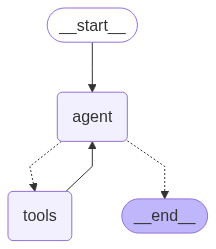

================================ Human Message =================================

As a localization developer, I want to enhance the relevancy check in the France eDocument country class with the new source type so that settlement management documents become relevant for the eDocument process and eDocuments are created for the source documents. How can I Achieve this?
================================== Ai Message ==================================
Tool Calls:
  sap_documentation_summary (call_FjT28FWvE2RYGhweKxpz1nTz)
 Call ID: call_FjT28FWvE2RYGhweKxpz1nTz
  Args:
    query: France eDocument relevancy check source type settlement management EDOC
================================= Tool Message =================================
Name: sap_documentation_summary

The information provided in the sources does not directly address the specific query about "France eDocument relevancy check source type settlement management EDOC." However, there are some related details about eDocument processes

In [6]:
if USE_MCP:
    async with MultiServerMCPClient(tools) as client:
        agent = ReActAgent(tool_list=client.get_tools())
        if DEBUG_MODE:
            print(agent.get_system_prompt())
            display(Image(agent.get_agent_graph()))

        await agent.arun_agent_with_input(user_message=QUERY, debug=DEBUG_MODE)
else:
    agent = ReActAgent(tool_list=tools)
    if DEBUG_MODE:
        print(agent.get_system_prompt())
        display(Image(agent.get_agent_graph()))

    agent.run_agent_with_input(user_message=QUERY, debug=DEBUG_MODE)

In [7]:
run_data = agent.get_execution_data()

run_data.pretty_print()

Agent Run Summary
Model Used:
o3

Execution Time: 
138.9 seconds

Token Consumption Statistics
  Input Tokens: 21117
  Output Tokens: 1409
  Total Tokens: 22526

LLM call count: 7

Tools Used:
  Tool #1:
    Name: sap_documentation_summary
    Arguments:
      query: France eDocument relevancy check source type settlement management EDOC
  Tool #2:
    Name: abap_method_codebase_search
    Arguments:
      query: France relevancy check class EDOC FR
  Tool #3:
    Name: edp_troubleshooting_search
    Arguments:
      query: settlement management edocument relevancy France is_relevant source type cl_edoc_source_stlmt
  Tool #4:
    Name: abap_method_codebase_search
    Arguments:
      query: cl_edocument_fr is_relevant
  Tool #5:
    Name: sap_help_lookup
    Arguments:
      query: eDocument settlement management assign type
  Tool #6:
    Name: abap_method_codebase_search
    Arguments:
      query: stlmt cl_edocument_fr_inv is_relevant


In [8]:
print(run_data.final_output)

Technical explanation (based only on tool output)

1. Locate the relevancy routine of the French country class  
   Tool “abap_method_codebase_search” returned the implementation of
   CL_EDOCUMENT_FR_INV→IS_RELEVANT:

```
IF  mo_source->mv_source_type <> cl_edoc_source_sd_invoice=>gc_src_sd_invoice
 AND mo_source->mv_source_type <> cl_edoc_source_fi_invoice=>gc_src_fi_invoice
 AND mo_source->mv_source_type <> cl_edoc_source_invoice_verif=>gc_src_inv_verif
 AND mo_source->mv_source_type <> cl_edoc_source_stlmt=>gc_src_stlmt_inv.
  rv_relevant = abap_false.
  RETURN.
ENDIF.
```

   • All listed source-types are explicitly admitted.  
   • If your new type is not in this list the method exits with
     RV_RELEVANT = space.

2. Add the new settlement-management source type  
   a. Make sure a constant exists in class CL_EDOC_SOURCE_STLMT
      (e.g. GC_SRC_STLMT_INV2 for the new SM scenario).  
   b. Enhance the IF-statement above:

```
AND mo_source->mv_source_type <> cl_edoc_source_stlm